In [1]:
# Call Required Libraries
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import shap as sp
import matplotlib.pyplot as plt
import scipy
import lime
import lime.lime_tabular
from tqdm import tqdm
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

C:\Users\User\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def main():
    Week_Choose = 5  
    #RandomState
    RS = 400
    DataWeekSplit(Week_Choose)
    x,y,SPWeight,df = InputData(Week_Choose)
    xgbm=xgb.XGBClassifier(learning_rate=0.01,
                           objective='binary:logistic',
                           scale_pos_weight=SPWeight,
                           n_estimators=200,
                           max_depth=4,
                           min_child_weight=6,
                           eval_metric='auc')
    rfm=RandomForestClassifier(n_estimators=100,
                           max_depth=4,
                           random_state=0)
    lrm=LogisticRegression(solver='saga',max_iter=10000)
    
    #Experiment_I(Week_Choose,RS,x,y,xgbm,rfm,lrm)
    #Experiment_II(Week_Choose,RS,x,y,xgbm,rfm,lrm)
    #AUROC_FiveTimes_Report(Week_Choose,x,y,xgbm,rfm,lrm)
    #Experiment_III(Week_Choose,RS,x,y,xgbm)
    #Experiment_IV(Week_Choose,RS,x,y,xgbm,df)
    

In [ ]:
def DataWeekSplit(W):
    dfD=pd.read_csv(os.getcwd()+'\\Dataset.csv')
    dfT=pd.read_csv(os.getcwd()+'\\Target_Weaning.csv')
    df1=pd.merge(left=dfT,right=dfD,on='No')
    df1.to_csv(os.getcwd()+'\\Dataset_Weaning_ByWeek.csv',index=False)
    # Original sort
    ft_0 = ["Input W","Output W","Fluid balance W","Feeding amount W","Urine output W","Urine & HD output W",
            "BT W","HR W","RR W","sysBP W","diaBP W","pulse pressure W","glucose W","SpO2 W",
            "Carbapenem W","Colistin W","Anti_fungal W","Anti_CMV W","Anti_MRSA W","Vasopressor W",
            "ALB W","BIL.T W","ALT W","WBC W","HGB W","PLT W",
            "FiO2 W","PEEP W","VTexp W","Minute ventilation W","PIP W","MAP W"]

    df1.index=range(0,len(df1.index))
    ftName=['No','DaysInW%d'%W]
    for i in range(0,len(df1.columns)):
        if df1.columns[i]=='Sex':
            break
    for j in range(i,len(df1.columns)):
        if df1.columns[j]=='Input W01':
            break
    for k in range(i,j):
        ftName.append(df1.columns[k])
        
    for k in range(j,len(df1.columns)):
        for i in range(0,len(ft_1)):
            for g in range(1,W):
                if df1.columns[k].find("%s%02d"%(ft_1[i],g))!=-1:
                    ftName.append(df1.columns[k])
    df1=df1[ftName]
    df1.to_csv(os.getcwd()+'\\Model_W%s_Weaning_ByWeek.csv'%W,index=False)

In [3]:
def InputData(W):  
    dataset = pd.read_csv(os.getcwd()+'\\Model_W%d_Weaning_ByWeek.csv'%W)
    dataset_alive=pd.read_csv(os.getcwd()+'\\Model_W%d_Weaning_ByWeek.csv'%W)
    dataset_dead=pd.read_csv(os.getcwd()+'\\Model_W%d_Weaning_ByWeek.csv'%W)
    times = 0
    for i in range(0,len(dataset.index)):
        if dataset['DaysInW%d'%W][i] == 1:
            times += 1
    if len(dataset.index) - times >= times:
        a = len(dataset.index) - times
        b = times
    else:
        a = times
        b = len(dataset.index) - times
    ScalePosWeight=a/b
    print('0: %d, 1: %d, Total: %d'%(len(dataset.index)-times,times,len(dataset.index)))
    
    df = ['No','DaysInW%d'%W,"Sex", "Weight", "Height", "Summary Diagnosis", "ICU APACHEII Total Score", "RCC APACHEII Total Score"]
    ft_1 = ["Input W","Output W","Fluid balance W","Feeding amount W","Urine output W","Urine & HD output W","Carbapenem W","Colistin W","Anti_fungal W","Anti_CMV W","Anti_MRSA W","Vasopressor W",
            "BT W","HR W","sysBP W","diaBP W","pulse pressure W","glucose W",
            "FiO2 W","PEEP W","VTexp W","Minute ventilation W","PIP W","MAP W","RR W","SpO2 W",
            "ALB W","BIL.T W","ALT W","WBC W","HGB W","PLT W"]
    ft = ["HTN", "DM", "CVA/dementia", "CHF", "Af", "COPD", "Asthma", "Summary Gastrointestinal_bleeding", "Summary Cirrhosis", "Summary ERSD",
          "NewHD", "Summary Active_Cancer", "Summary Cancer_history", "Summary Autoimmunity", "Summary Organ_transplantation"]
    for i in range(0,len(ft_1)):
        for j in range(1,W):
            df.append("%s%02d"%(ft_1[i],j))
    for i in range(0,len(ft)):       
        df.append(ft[i])
    dataset = dataset.reindex(columns=df)
    #dataset.to_csv('dataset_test.csv', index=False)
    
    x = dataset.drop(columns = ['No','DaysInW%d'%W])
    y = dataset['DaysInW%d'%W]
    
#    table1 = pd.DataFrame([ftName, total_avg, alive_avg, dead_avg, p_value]).T
#    table1.columns = ['column_name', 'Total n=' + str(len(dataset[dataset.columns[i]])), 'Alive n=' + str(len(dataset_alive[dataset_alive.columns[i]])), 'Dead n=' + str(len(dataset_dead[dataset_dead.columns[i]])), 'P Value']
#    table1.to_csv('AVG_Weaning.csv', index=False)
    return x,y,ScalePosWeight,df

In [4]:
#Model_Report
def Experiment_I(W,RS,x,y,xgbm,rfm,lrm):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RS)
    
    xgbm=xgbm.fit(x_train,y_train)
    y_pred_xgb = xgbm.predict(x_test)
    y_prob_xgb = xgbm.predict_proba(x_test)[:,1]
    report = classification_report(y_test,y_pred_xgb,labels=[0,1],output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(os.getcwd()+'\\Model_W%d_Weaning_XGBReport.csv'%W)
    
    rfm=rfm.fit(x_train,y_train)
    y_pred_rf=rfm.predict(x_test)
    y_prob_rf=rfm.predict_proba(x_test)[:,1]
    report = classification_report(y_test,y_pred_rf,labels=[0,1],output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(os.getcwd()+'\\Model_W%d_Weaning_RFReport.csv'%W)
    
    lrm=lrm.fit(x_train,y_train)
    y_pred_lr=lrm.predict(x_test)
    y_prob_lr=lrm.predict_proba(x_test)[:,1]
    report = classification_report(y_test,y_pred_lr,labels=[0,1],output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(os.getcwd()+'\\Model_W%d_Weaning_LRReport.csv'%W)

In [5]:
#AUROC
def Experiment_II(W,RS,x,y,xgbm,rfm,lrm):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RS)
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    xgbm=xgbm.fit(x_train,y_train)
    y_prob_xgb = xgbm.predict_proba(x_test)[:,1]
    fpr,tpr,threshold=roc_curve(y_test,y_prob_xgb)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,'r',label='XGB (%.3F)'%roc_auc,linestyle='-')
    rfm=rfm.fit(x_train,y_train)
    y_prob_rf = rfm.predict_proba(x_test)[:,1]
    fpr,tpr,threshold=roc_curve(y_test,y_prob_rf)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,'g',label='RF (%.3F)'%roc_auc,linestyle='-.')
    lrm=lrm.fit(x_train,y_train)
    y_prob_lr = lrm.predict_proba(x_test)[:,1]
    fpr,tpr,threshold=roc_curve(y_test,y_prob_lr)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,'b',label='LR (%.3F)'%roc_auc,linestyle=':')
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right',frameon=False)
    plt.savefig("Model_W%d_Weaning_AUROC.png"%W)

In [6]:
def AUROC_FiveTimes_Report(W,x,y,xgbm,rfm,lrm):
    FiveTimes_Report=[['XGB'],['RF'],['LR']]
    RD = [0,1000,800,600,400]
    for i in range(0,5):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RD[i])
        
        xgbm=xgbm.fit(x_train,y_train)
        y_prob_xgb = xgbm.predict_proba(x_test)[:,1]   
        fpr,tpr,threshold=roc_curve(y_test,y_prob_xgb)
        roc_auc='%.3f'%auc(fpr,tpr)
        FiveTimes_Report[0].append(roc_auc)
        
        rfm=rfm.fit(x_train,y_train)
        y_prob_rf=rfm.predict_proba(x_test)[:,1]
        fpr,tpr,threshold=roc_curve(y_test,y_prob_rf)
        roc_auc='%.3f'%auc(fpr,tpr)
        FiveTimes_Report[1].append(roc_auc)
        
        lrm=lrm.fit(x_train,y_train)
        y_prob_lr=lrm.predict_proba(x_test)[:,1]
        fpr,tpr,threshold=roc_curve(y_test,y_prob_lr)
        roc_auc='%.3f'%auc(fpr,tpr)
        FiveTimes_Report[2].append(roc_auc)
        
    df = pd.DataFrame(FiveTimes_Report)   
    df.to_csv(os.getcwd()+'\\Model_W%d_Weaning_FiveTimes_Report.csv'%W,index=False)    

In [7]:
#XGB SHAP
def Experiment_III(W,RS,x,y,xgbm):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RS)
    xgbm=xgbm.fit(x_train,y_train)
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    explainer=sp.TreeExplainer(xgbm,feature_perturbation='tree_path_dependent')
    shap_values=explainer.shap_values(x_test)
    sp.summary_plot(shap_values,x_test,show=False)
    plt.tight_layout()
    plt.savefig("Model_W%d_Weaning_SHAP.png"%W)

In [8]:
#XGB FeatureImportance
def Experiment_IV(W,RS,x,y,xgbm,df=[]):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=RS)
    xgbm=xgbm.fit(x_train,y_train)
    explainer=sp.TreeExplainer(xgbm,feature_perturbation='tree_path_dependent')
    shap_values=explainer.shap_values(x_test)
    shap_sum = np.abs(shap_values).mean(axis=0)

    importance_df = pd.DataFrame([x_test.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance']
    val = [[],[],[],[],[],[]]
    temp = [[],[],[],[],[]]
    #classification
        # xgbSHAP
        
    #val[1] = list(importance_df['shap_importance'][0:4]) + list(importance_df['shap_importance'][19:45]) + list(importance_df['shap_importance'][77:101])
    #val[2] = list(importance_df['shap_importance'][45:53]) + list(importance_df['shap_importance'][57:73])
    #val[3] = list(importance_df['shap_importance'][125:]) + list(importance_df['shap_importance'][73:77]) + list(importance_df['shap_importance'][53:57])
    #val[4] = list(importance_df['shap_importance'][101:125])
    #val[5] = list(importance_df['shap_importance'][4:19])
        
        # xgb
    xgbmFI = xgbm.feature_importances_
    val[1] = list(xgbmFI[0:6]) + list(xgbmFI[6:(6+12*(W-1)+1)])
    temp[1] = 6+11*(W-1)+1
    val[2] = list(xgbmFI[temp[1]:(temp[1]+6*(W-1)+1)])
    temp[2] = temp[1]+6*(W-1)+1
    val[3] = list(xgbmFI[temp[2]:(temp[2]+8*(W-1)+1)])
    temp[3] = temp[2]+8*(W-1)+1
    val[4] = list(xgbmFI[temp[3]:(temp[3]+6*(W-1)+1)])
    temp[4] = temp[3]+6*(W-1)+1
    val[5] = list(xgbmFI[temp[4]:])

    #check
    for i in range(1,6):
        print('Domain'+str(i), ', '+str(sum(val[i])))
    importance_df = importance_df.sort_values('shap_importance', ascending=False)
    for i in range((21+(31*(W-1)))):
        #print(importance_df['column_name'][i], importance_df['shap_importance'][i])
        print(importance_df['column_name'][i], ', '+str(xgbmFI[i])) 
        
    domain = [[],[],[],[],[],[]]
    # 其他 + 輸液灌食 + 特殊藥物
    domain[1] = df[2:8+4*(W-1)+1] + df[8+4*(W-1)+W:temp[1]+2]
    # 生理參數
    domain[2] = df[temp[1]+2:temp[2]+2]
    # 呼吸照護
    domain[3] = df[temp[2]+2:temp[3]+2]
    # 檢驗檢查
    domain[4] = df[temp[3]+2:temp[4]+2]
    # 共病
    domain[5] = df[temp[4]+2:]
    
    plt_title = []
    plt_value = []
    for i in range(5,30):
        if i%5==0:
            plt_title.append('domain'+str(i//5))
            plt_value.append(sum(val[i//5]))
        plt_title.append(domain[i//5][val[i//5].index(max(val[i//5]))])
        domain[i//5].remove(domain[i//5][val[i//5].index(max(val[i//5]))])
        plt_value.append(max(val[i//5]))
        val[i//5].remove(max(val[i//5]))
    
    # 將 top25 的機率加起來為 1，顯示個別的重要性
    for i in range(5):
        plt_value[i*6+1] *= (plt_value[i*6] / sum(plt_value[i*6+1:(i+1)*6]))
        plt_value[i*6+2] *= (plt_value[i*6] / sum(plt_value[i*6+1:(i+1)*6]))
        plt_value[i*6+3] *= (plt_value[i*6] / sum(plt_value[i*6+1:(i+1)*6]))
        plt_value[i*6+4] *= (plt_value[i*6] / sum(plt_value[i*6+1:(i+1)*6]))
        plt_value[i*6+5] *= (plt_value[i*6] / sum(plt_value[i*6+1:(i+1)*6]))
    
    plt_title.reverse()
    plt_value.reverse()

    plt.figure(figsize=(20,15))
    plt.barh(plt_title, plt_value,color=['cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','navy','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','navy','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','navy','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','cornflowerblue','navy'])
    plt.title('domain Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    for i, v in enumerate(plt_value):
        color = ''
        if i % 6 == 5: 
            color = 'navy'
        else: 
            color = 'cornflowerblue'
        plt.text(v, i, '%.2f'%(v), color=color, fontweight='bold')

    plt.tight_layout()
    plt.savefig("Model_W%d_Weaning_FeatureImportance.png"%W)
            

0: 714, 1: 249, Total: 963


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


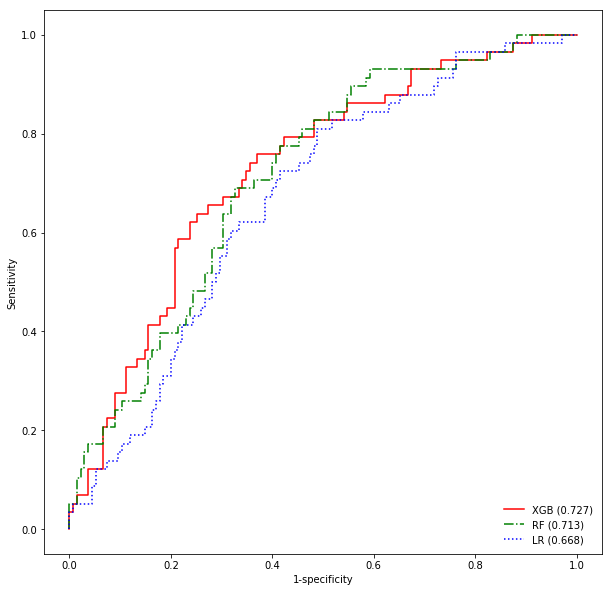

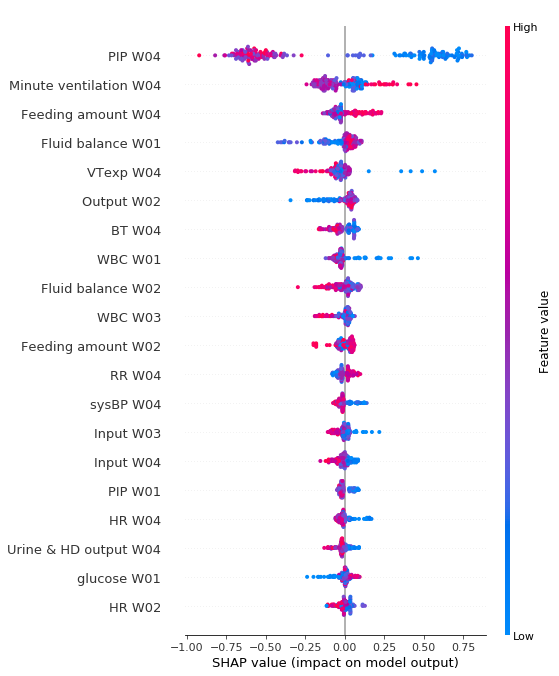

In [11]:
if __name__ is '__main__':
    main()